In [1]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import os

# enable R cells
%load_ext rpy2.ipython

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# requires apt-get install r-base
os.environ["R_HOME"]="/usr/lib/R/"

#### Load Database in R

export to rdf variable

In [2]:
%%R -o rdf
load("Databases/UCR-4.RData.bak")
database[1]
rdf <- data.frame(database);

## Dataset inspection

inspect single examples in python

In [3]:
print(rdf.shape)
print(rdf.columns)

(930, 130)
Index(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       ...
       'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'tt',
       'c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..'],
      dtype='object', length=130)


field `tt` seems to be the training or test split

In [4]:
print(np.sum(rdf["tt"]==0.0))
print(np.sum(rdf["tt"]==1.0))

30
900


In [5]:
print(pd.unique(rdf["tt"]))
print(pd.unique(rdf["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]))

[0. 1.]
[1. 3. 2.]


**findings/questions**:

the dataset `UCR-4.RData` seems to be `CBF` http://www.timeseriesclassification.com/description.php?Dataset=CBF

* values start from `V2` (where is `V1`?)
* field 'tt' seems to be the training (`0.0`) or test (`1.0`) split
* field `c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..` is likely the label `1` `2` `3`. **It has a a very strange name**, though.

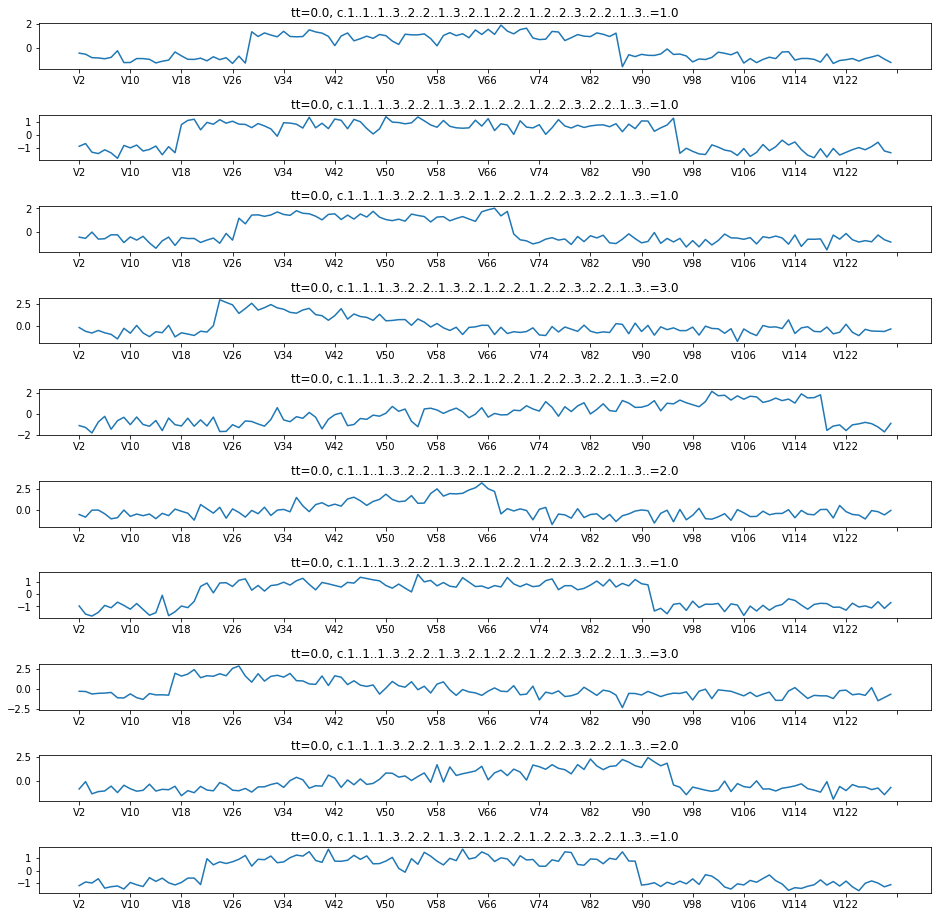

In [6]:
# take only V* columns
values = rdf.filter(regex="V")

n=10
fig,ax = plt.subplots(n,1,figsize=(16,16))
for i in range(n):
    ax[i].plot(values.iloc[i])
    
    tt=rdf.iloc[i]["tt"]
    c=rdf.iloc[i]["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]
    
    title="tt={}, c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..={}".format(tt,c)
    ax[i].set_title(title)
    
    # plot fewer ticks
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

##### Functions for loading and parsing the BavarianCrops Dataset

In [7]:

def filter_n_times(X, samplet=70):
    """
    X has variable lengths. Hence, it can not be stacked to one numpy array [batchsize x times x n_channels]
    This function randomly chooses <samplet> observations from each X time series and outputs subsabpled
    sequences of fixed size
    the NN implementation does this online whenever a sample is loaded from disk
    """

    new_X = list()
    for X_ in X:
        
        t = X_.shape[0]

        idxs = np.random.choice(t, samplet, replace=False)
        idxs.sort()
        
        new_X.append(X_[idxs])
        
    return np.array(new_X)


def parse_to_format(X, classweights, y, ndims, sequencelengths, sequencelength, ids, tt=0.0):
    N,t = X.shape
    valuenames = ["V{}".format(t) for t in range(2,t+2)] # V2, V3, V4, ..., VT

    df = pd.DataFrame(X, columns=valuenames)
    df["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."] = y
    df["tt"] = tt
    
    return df

def load_BavarianCrops_dataset(cache, tt):

    classweights = np.load(os.path.join(cache, "classweights.npy"), allow_pickle=True)
    y = np.load(os.path.join(cache, "y.npy"), allow_pickle=True)
    ndims = int(np.load(os.path.join(cache, "ndims.npy"), allow_pickle=True))
    sequencelengths = np.load(os.path.join(cache, "sequencelengths.npy"), allow_pickle=True)
    sequencelength = sequencelengths.max()

    ids = np.load(os.path.join(cache, "ids.npy"), allow_pickle=True)
    #self.dataweights = np.load(os.path.join(self.cache, "dataweights.npy"))
    X = np.load(os.path.join(cache, "X.npy"), allow_pickle=True)
    """features Sentinel 2 Bands
    ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'QA10', 'QA20', 'QA60', 'doa', 'label', 'id']"""
    
    X = filter_n_times(X,samplet=70)
    
    # mean aggregate over features to get uni-variate time series
    #X = X.mean(2)
    
    # calculate NDVI to have an univariate TS https://de.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index
    B08 = X[:,:,10] # Near infrared
    B04 = X[:,:,6] # red channel
    X = (B08 - B04) / (B08 + B04)
    
    df = parse_to_format(X, classweights, y, ndims, sequencelengths, sequencelength, ids, tt)
    
    return df


### Load the BavarianCrops dataset from npy arrays

In [8]:
df_train = load_BavarianCrops_dataset("Databases/BavarianCrops/train/", tt=0.0)
df_valid = load_BavarianCrops_dataset("Databases/BavarianCrops/valid/", tt=0.0)
df_test = load_BavarianCrops_dataset("Databases/BavarianCrops/eval/", tt=1.0)

BavarianCrops = pd.concat([df_train, df_valid, df_test])

train=BavarianCrops.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

### Show some examples

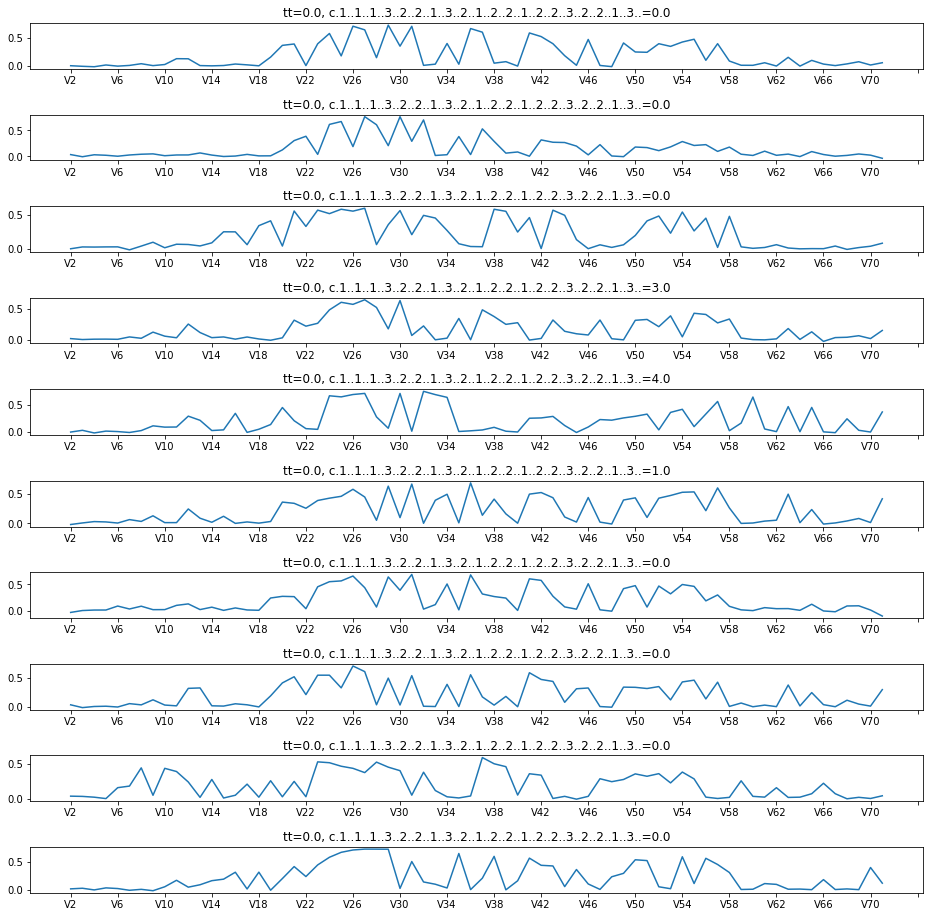

In [9]:
# take only V* columns
values = df_train.filter(regex="V")

n=10
fig,ax = plt.subplots(n,1,figsize=(16,16))
for i in range(n):
    ax[i].plot(values.iloc[i])
    
    tt=df_train.iloc[i]["tt"]
    c=df_train.iloc[i]["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]
    
    title="tt={}, c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..={}".format(tt,c)
    ax[i].set_title(title)
    
    # plot fewer ticks
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

### save full dataset as .rData

In [10]:
%%R -i train -i classes

database<-list(train)

database[[2]] <- classes

save(database, file = "Databases/BavarianCrops.RData")

### save smaller subset as .rData

In [11]:
BavarianCrops_small = BavarianCrops.sample(1000)

train=BavarianCrops_small.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [12]:
%%R -i train -i classes

database<-list(train)

database[[2]] <- classes

save(database, file = "Databases/BavarianCrops_small.RData")

### Test if loading works
with code from Mori et al. 2017

In [13]:
%%R -o train -o classes
load("Databases/BavarianCrops_small.RData")
#load("Databases/UCR-4.RData")
train<-database[[1]][database[[1]]$tt==0,]
train$tt<-NULL
classes<-as.factor(database[[2]][which(database[[1]]$tt==0)])
train <- data.frame(train);
classes <- data.frame(classes);